In [79]:
import pandas as pd
import numpy as np
import summarytools
import mysql.connector


# Inspect Data

In [80]:
# Connect with mysql database
connection = mysql.connector.connect(
    host='localhost',      # Replace with your database host
    user='root',  # Replace with your username
    password='1234',  # Replace with your password
    database='house'   # Replace with your database name
)

query = "SELECT * FROM house"
df = pd.read_sql(query, connection)
connection.close()


summarytools.dfSummary(df)

C:\Users\Ying\AppData\Local\Temp\ipykernel_21272\1775808620.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,address[object],1. 1102 BL (Amsterdamse Poort e.o2. 2132 HE (Hoofddorp Zuid)3. 1062 AC (Overtoomse Veld)4. 1441 DR (Binnenstad)5. 1013 BD (Houthavens)6. 2011 RZ (Bakenes)7. 3527 DZ (Kanaleneiland-Noord)8. 6222 CS (Limmel)9. 5611 EC (Binnenstad)10. 2288 DC (Plaspoelpolder)11. other,"19 (0.9%)11 (0.5%)11 (0.5%)9 (0.4%)6 (0.3%)5 (0.2%)5 (0.2%)5 (0.2%)4 (0.2%)4 (0.2%)2,122 (96.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6NJREFUeJzt3DFuG1cYRtF/BEKxmiEIAlpCsgctwov1IriI7EEQNEXkqGGKpIngGHDhOwBzTiWwesUFH0nMp+V6vQ4U7vY+AP8fYiMjNjJiIyM2MmIjIzYyYiMjNjLLzDzMzFyv17edz8KNO5zP588zM8uyfBEcP9Pduq6ndV1PM3O/92G4bT6zkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZw7ZtL//8/b7rSbh5NghkFv8yi4p3NjLWVWSsq8j46YOM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmPhZMxeCHjnY2MwQsZgxcyfvogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELGY+FkDF7I+MxGxjVKxrqKjHUVGZ/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeR8Vg4GesqMj6zkblbluW3ZVk+7X0Qbt/dzPw6M7/sfRBun2uUjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M3cz8PjN/7n0Qbp8NAhnXKBmxkTF4IWPwQsY1SkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcY2SERsZ6yoy1lVkXKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxjZIRGxmDFzIGL2Rco2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHGNkhEbGbGRsa4iY11FxjVKRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbGuoqMdRUZ1ygZsZExeCFj8ELGNUpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXKJllZh5m5n7vg3BT3q/X69vHFw/n8/nzuq6nPU7Ebdq27WVZli8fgzus63p6enp6Ox6PX/c6HLfj9fX10+VyOT0/P9/PzL9jm5k5Ho9fHx8f/9jldNyih2+96AsCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmcPM34+F7H0QbsP3Wjps2/ZyuVxO8x+PhcCP2rbtZWbeP77usXB+hm8+Fm5dRcYXBDJiIyM2MmIjIzYyYiMjNjJiIyM2Mn8BS2qu7EAmsPMAAAAASUVORK5CYII="">",0(0.0%)
2,agent_name[object],1. Verhuurtbeter.nl2. Hausing3. Gruno Vastgoed B.V.4. HouseHunting Eindhoven5. Rotterdam Apartments6. Amsterdam Housing7. HouseHunting Randstad8. Rotsvast Eindhoven9. Huizenbalie.nl10. Rental Rotterdam11. other,"50 (2.3%)36 (1.6%)33 (1.5%)26 (1.2%)24 (1.1%)23 (1.0%)23 (1.0%)22 (1.0%)20 (0.9%)20 (0.9%)1,924 (87.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAABClJREFUeJzt3UFqG2cAhuHfQrj2ZoQQ+Bg+gA6Rw+YQOkDuYYxmEbnZuIsqwcmihaJ51arPswkRRMziZRQN/2ffvb+/Dyisrn0B/H+IjYzYyIiNjNjIiI2M2MiIjYzYyNyNMR7HGPcfXvv2/v5+utL1cMPWu93u0zRN2+8vzPP8end391lwXNp6mqbtfr8/bTabt+Px+HA4HLYvLy/3YwyxcVHrMcbYbDZvT09PX8+vPV7xerhhviCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ9RhjHI/Hh49/whLW8zy/Hg6H7TifY5vn+XWM8e26l8UtskEgc+dHZlH59c7mrsZiflpXWVaxpNX3ddV+vz+do7v/238F/8CPddX575ZVLMZDXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjI/DV5gSR8HL8YuLMqxcDIGL2Q+3tnc1VjUj8GLsQtLW03TtH1+fh7GLixtNcYYj4+Pv1/7Qrh9HuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY0xxul0+u3aF8LtW83z/PrlyxdjFxbnWDgZgxcyviCQ8TFKxrqKjHUVGesqMr4gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWTc2cgYvJAxeCFj8ELGQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOBZOxuCFjDsbGYMXMgYvZAxeyHioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkbFBIGNdRcadjYx1FRnrKjLWVWQ81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IuLORMXghY/BCxuCFjIe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEsnIzBCxlfEMh8/xgdPkJZ2nq3230aYwzLKpa2mqZpa1lFwf/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIrM+rqjEsq1iYY+FkrKvIuLORMXghY/BCxqMPMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kHAsnY/BC5uMvSoNfXfSX5613u92n8wYBfjLP8+slh1DraZq2+/3+tNls3i7xhtyG4/H4cDgcti8vL/djjMvENsYYm83m7enp6esl3pCb8njJN/OcjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcx6jD+Pk1z7Qvh3WaKJ9TzPr4fDYTsufJyE/77zGOpiQyjHwvkrFz0WbvBCxhcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwBxJKgWepp2XQAAAABJRU5ErkJggg=="">",0(0.0%)
3,agent_url[object],1. https://www.pararius.com/real-2. h

# Data Cleasing

In [81]:
df = df.drop(columns = ['address', 'agent_name', 'agent_url', 'house_name', 'description', 'house_url', 'maximum_months', 'minimum_months', 'status'])

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   available             1859 non-null   object 
 1   balcony               2010 non-null   object 
 2   city                  2201 non-null   object 
 3   construction_type     2040 non-null   object 
 4   deposit               1373 non-null   float64
 5   district              2201 non-null   object 
 6   dwelling_type         2201 non-null   object 
 7   energy_rating         1737 non-null   object 
 8   interior              1832 non-null   object 
 9   living_area_m2        2201 non-null   float64
 10  number_of_bathrooms   1540 non-null   float64
 11  number_of_bedrooms    1793 non-null   float64
 12  number_of_rooms       2201 non-null   int64  
 13  offered_since         2201 non-null   object 
 14  pets_allowed          904 non-null    object 
 15  price                

In [83]:
print(df['balcony'].unique()) # fillna with not present
print(df['construction_type'].unique()) # fillna with mode
print(df['dwelling_type'].unique())
print(df['interior'].unique()) # fillna using relationship
# print(df['property_type'].unique())
print(df['rental_agreement'].unique()) # fillna with not specified
print(df['smoking_allowed'].unique())
print(df['pets_allowed'].unique())

['Not present' 'Present' None]
['Existing building' 'New development' None]
['Flat' 'House' 'Room' 'Studio']
['Upholstered' 'Furnished' None 'Upholstered or furnished' 'Shell']
[None 'Unlimited period' 'Temporary rental']
[None 'No' 'Yes']
[None 'No' 'Yes']


In [84]:
df['balcony'] = df['balcony'].fillna('Not present')
df['construction_type'] = df['construction_type'].fillna(df['construction_type'].mode()[0])
df['interior'] = df['interior'].fillna('Not specified')
df['rental_agreement'] = df['rental_agreement'].fillna('Not specified')
df['pets_allowed'] = df['pets_allowed'].fillna('No')
df['smoking_allowed'] = df['smoking_allowed'].fillna('No')

In [85]:
# Impute number_of_bedrooms and number_of_bathrooms
median_bathrooms = int(df['number_of_bathrooms'].median())

# Imputation logic
def ImputeBedrooms(row):
    if pd.isnull(row['number_of_bedrooms']):
        # Set to 1 if dwelling type is 'room'
        if row['dwelling_type'] == 'room':
            return 1  
        elif not pd.isnull(row['number_of_rooms']) and not pd.isnull(row['number_of_bathrooms']):
            # If both rooms and bathrooms are not null 
            if row['number_of_rooms'] - row['number_of_bathrooms'] <= 0:
                return row['number_of_rooms'] 
            else:
                return row['number_of_rooms'] - row['number_of_bathrooms']
        elif not pd.isnull(row['number_of_rooms']):
            return row['number_of_rooms']
    return row['number_of_bedrooms']

def ImputeBathrooms(row):
    if pd.isnull(row['number_of_bathrooms']):
        return median_bathrooms 
    return row['number_of_bathrooms']

def TransformRooms(row):
    rooms = row['number_of_bathrooms'] + row['number_of_bedrooms']
    return rooms

# Apply the logic
df['number_of_bedrooms'] = df.apply(ImputeBedrooms, axis=1)
df['number_of_bathrooms'] = df.apply(ImputeBathrooms, axis=1)
df['number_of_rooms'] = df.apply(TransformRooms, axis = 1)

df['number_of_bathrooms'] = df['number_of_bathrooms'].astype('int32')
df['number_of_bedrooms'] = df['number_of_bedrooms'].astype('int32')
df['number_of_rooms'] = df['number_of_rooms'].astype('int32')

In [86]:
# service cost category column
def CategorizeServiceCost(value):
    if pd.isnull(value) or value.lower() == 'none':  # Handle NaN or 'None'
        return 'Not specified'
    value = value.lower()
    if 'electricity' in value and 'gas' in value and 'water' in value and 'internet' in value:
        return 'All included'
    elif 'electricity' in value or 'gas' in value or 'water' in value or 'internet' in value:
        return 'Partial included'
    elif 'excludes' in value:
        return 'Not included'
    else:
        return 'Not specified'

df['service_cost_category'] = df['service_cost'].astype(str).apply(CategorizeServiceCost)

## Transform date columns

In [87]:
from datetime import datetime, timedelta
def StringToDate(value):
    if not pd.isnull(value):
        date = datetime.strptime(value,'%d-%m-%Y')
        return date

df['available'] = df['available'].apply(StringToDate)
df['offered_since'] = df['offered_since'].apply(StringToDate)

df['offer_to_available'] = (df['available'] - df['offered_since']).dt.days

median_duration = int(df['offer_to_available'].median())
df['offer_to_available'] = df['offer_to_available'].fillna(median_duration)

def AvailableFillNa(row):
    if pd.isnull(row['available']):
        date = row['offered_since'] + timedelta(days = median_duration)
        return date
    return row['available']

df['available'] = df.apply(AvailableFillNa, axis=1)

# extract month
month_dic = {1:'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May.', 6: 'Jun.', 7: 'Jul', 8: 'Aug.', 9: 'Sep.', 10: 'Oct', 11: 'Nov.', 12: 'Dec'}
def GetMonth(value):
    return month_dic[value.month]

df['offered_month'] = df['offered_since'].apply(GetMonth)
df['available_month'] = df['available'].apply(GetMonth)



# house age
df['house_age'] = df['offered_since'].dt.year - df['year_of_construction']
df['house_age'] = df['house_age'].fillna(df['house_age'].median())
df = df.drop(columns = ['year_of_construction'])

df = df.drop(columns = ['available','offered_since'])


## Impute energy_rating

In [88]:
def ToIntegerScale(value):
    if value is not None:
        if value == 'G':
            return 1
        elif value == 'F':
            return 2
        elif value == 'E':
            return 3
        elif value == 'D':
            return 4
        elif value == 'C':
            return 5
        elif value == 'B':
            return 6
        elif value == 'A':
            return 7
        elif '+' in value:
            lis = list(value)
            extra = lis.count('+')
            return 7+extra
    return value

df['energy_rating'] = df['energy_rating'].apply(ToIntegerScale)


In [89]:
train_data = df[df['energy_rating'].notna()]
correlation = train_data[['energy_rating', 'house_age', 'living_area_m2']].corr()
print(f"Correlation for house age and living_area_m2: {correlation}")

from scipy.stats import f_oneway

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['energy_rating'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling_type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['energy_rating'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling Type:", anova_dwelling)

Correlation for house age and living_area_m2:                 energy_rating  house_age  living_area_m2
energy_rating        1.000000  -0.311922       -0.088817
house_age           -0.311922   1.000000       -0.021225
living_area_m2      -0.088817  -0.021225        1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(1.7275085632170124), pvalue=np.float64(1.7852169272406729e-09))
ANOVA for Dwelling Type: F_onewayResult(statistic=np.float64(22.19916064783507), pvalue=np.float64(3.022639099145275e-10))


In [90]:
from sklearn.ensemble import RandomForestClassifier

# Train data (rows without missing energy_rating)
train_data = df[df['energy_rating'].notna()]
X_train = train_data[['dwelling_type', 'city']]
y_train = train_data['energy_rating']

# Test data (rows with missing energy_rating)
test_data = df[df['energy_rating'].isna()]
X_test = test_data[['dwelling_type', 'city']]

# One-hot encoding for categorical features
# One-hot encoding for X_train
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# One-hot encoding for X_test
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the columns of X_test_encoded with X_train_encoded
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Train model and predict
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)
df.loc[df['energy_rating'].isna(), 'energy_rating'] = model.predict(X_test_encoded)


## Impute deposit

In [91]:
train_data = df[df['deposit'].notna()]
correlation = train_data[['deposit','price']].corr()
print(f"Correlation for deposit and price: {correlation}")

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['deposit'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['deposit'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling_type:", anova_dwelling)


Correlation for deposit and price:           deposit     price
deposit  1.000000  0.900232
price    0.900232  1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(5.5684035498783695), pvalue=np.float64(2.671917670885024e-76))
ANOVA for Dwelling_type: F_onewayResult(statistic=np.float64(94.71167235855725), pvalue=np.float64(1.060761334956301e-55))


In [92]:
# Impute deposit by city and dwelling_type
df['deposit'] = df['deposit'].fillna(
    df.groupby(['city', 'dwelling_type'])['deposit'].transform('median')
)

df['deposit'] = df['deposit'].fillna(df['deposit'].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   balcony                2201 non-null   object 
 1   city                   2201 non-null   object 
 2   construction_type      2201 non-null   object 
 3   deposit                2201 non-null   float64
 4   district               2201 non-null   object 
 5   dwelling_type          2201 non-null   object 
 6   energy_rating          2201 non-null   float64
 7   interior               2201 non-null   object 
 8   living_area_m2         2201 non-null   float64
 9   number_of_bathrooms    2201 non-null   int32  
 10  number_of_bedrooms     2201 non-null   int32  
 11  number_of_rooms        2201 non-null   int32  
 12  pets_allowed           2201 non-null   object 
 13  price                  2201 non-null   float64
 14  property_type          2040 non-null   object 
 15  rent

## Inspect correlation

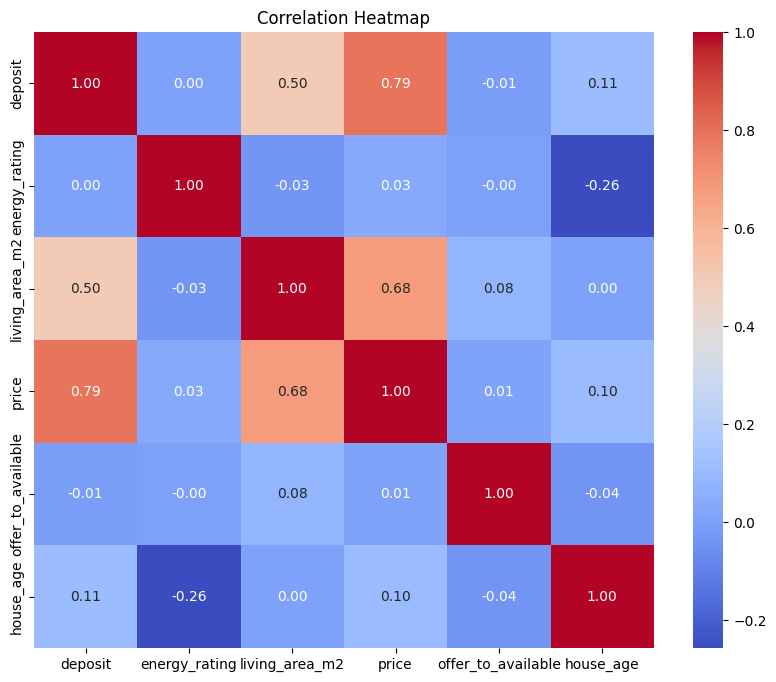

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()


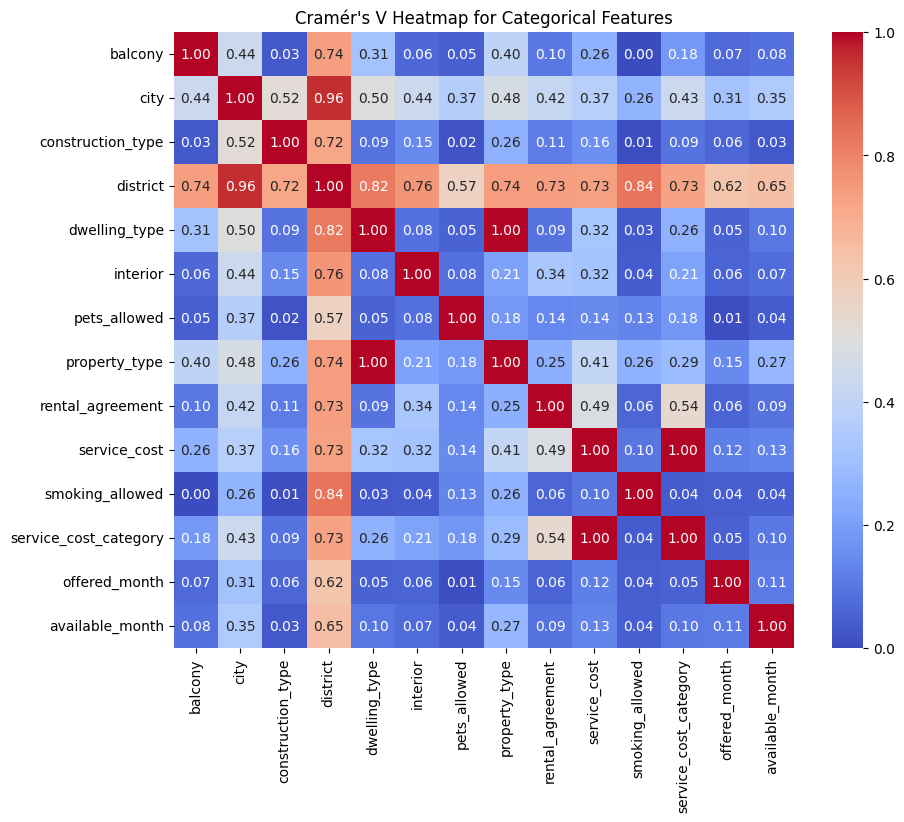

In [94]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Function to calculate Cramér's V matrix
def cramers_v_matrix(df, categorical_features):
    matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
    for col1 in categorical_features:
        for col2 in categorical_features:
            contingency_table = pd.crosstab(df[col1], df[col2])
            matrix.loc[col1, col2] = cramers_v(contingency_table)
    return matrix.astype(float)

# List of categorical features
categorical_features = ['balcony', 'city', 'construction_type',
       'district', 'dwelling_type', 'interior',
       'pets_allowed', 'property_type', 'rental_agreement', 'service_cost', 'smoking_allowed',
       'service_cost_category', 'offered_month', 'available_month']

# Compute Cramér's V matrix
cramers_v_matrix_df = cramers_v_matrix(df, categorical_features)

# Ensure diagonal elements are 1
np.fill_diagonal(cramers_v_matrix_df.values, 1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cramér's V Heatmap for Categorical Features")
plt.show()


In [95]:
df = df.drop(columns = ['property_type', 'district', 'service_cost'])

## One-Hot Encoding

In [96]:
df.columns

Index(['balcony', 'city', 'construction_type', 'deposit', 'dwelling_type',
       'energy_rating', 'interior', 'living_area_m2', 'number_of_bathrooms',
       'number_of_bedrooms', 'number_of_rooms', 'pets_allowed', 'price',
       'rental_agreement', 'smoking_allowed', 'service_cost_category',
       'offer_to_available', 'offered_month', 'available_month', 'house_age'],
      dtype='object')

In [97]:
from sklearn.preprocessing import OneHotEncoder
df = pd.get_dummies(df, columns = ['balcony','city','construction_type', 'dwelling_type', 'interior', 'pets_allowed', 'rental_agreement',
                                   'smoking_allowed', 'service_cost_category', 'offered_month', 'available_month'])
df.head()

,deposit,energy_rating,living_area_m2,number_of_bathrooms,number_of_bedrooms,number_of_rooms,price,offer_to_available,house_age,balcony_Not present,...,offered_month_Dec,offered_month_Nov.,offered_month_Oct,available_month_Dec,available_month_Feb.,available_month_Jan.,available_month_Jul,available_month_Jun.,available_month_Mar.,available_month_Nov.
0,3500.0,6.0,81.0,1,2,3,1750.0,21.0,19.0,True,...,True,False,False,True,False,False,False,False,False,False
1,3600.0,7.0,67.0,1,1,2,1800.0,2.0,14.0,False,...,True,False,False,True,False,False,False,False,False,False
2,2000.0,7.0,54.0,1,1,2,1100.0,21.0,6.0,True,...,True,False,False,True,False,False,False,False,False,False
3,2000.0,3.0,42.0,1,1,2,845.0,21.0,45.0,True,...,False,True,False,True,False,False,False,False,False,False
4,2000.0,7.0,40.0,1,1,2,1200.0,14.0,0.0,True,...,False,True,False,True,False,False,False,False,False,False


## Inspect distribution

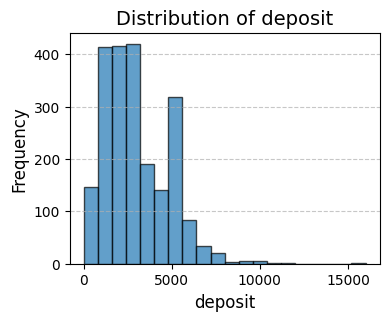

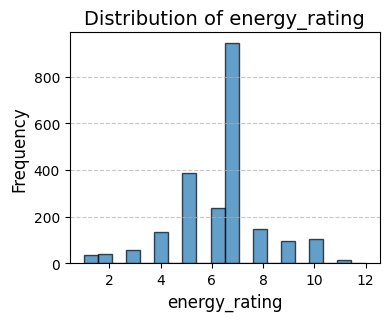

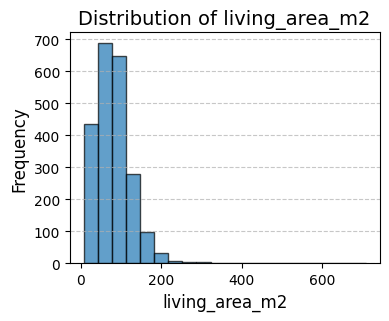

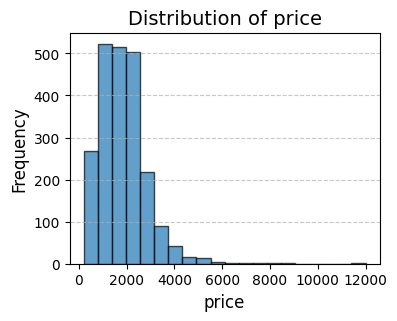

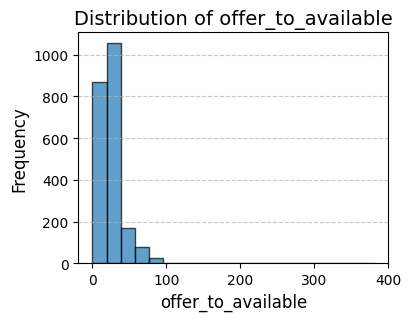

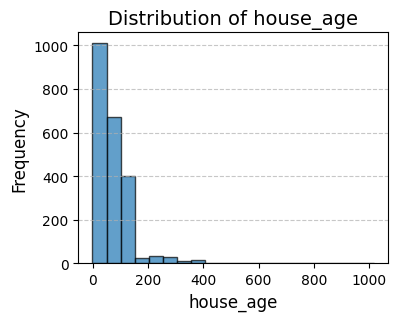

In [101]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Loop through each numeric column and plot its distribution
for column in numeric_columns:
    plt.figure(figsize=(4, 3))  # Set figure size
    plt.hist(df[column].dropna(), bins=20, edgecolor='k', alpha=0.7)  # Drop NaNs and plot histogram
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines
    plt.show()


# Split and transform data

In [99]:
# Split the data for the common use
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['price']).copy()
y = df['price'].copy()
# split data to train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [100]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns = ['energy_rating','price']).columns
for c in numeric_columns:
    X_train[c] = np.log(X_train[c] + 1)
    X_test[c] = np.log(X_test[c] + 1) 

y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)


d:\Side Projects\Scrapy_Pararius\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
